# Imports

In [1]:
import gensim
import ujson as json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging
from collections import defaultdict
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
LOAD_FROM_FILE = True
DATAFRAME_FILE = 'data/flavor_space.parquet'
FLAVMOL_FILE = 'data/flavor_mol.parquet'
MODEL_FILES = {'cbow': 'data/flavor2vec-cbow.model', 'skip': 'data/flavor2vec-skipgram.model'}

In [3]:
## fix issue when different version of gensim is used
from pip._vendor import pkg_resources

def get_version(package):
    package = package.lower()
    return next((p.version for p in pkg_resources.working_set if p.project_name.lower() == package), "No match")
gensim_version = int(get_version("gensim").split(".")[0] )

# Prepare datasets

In [4]:
if LOAD_FROM_FILE:
    df = pd.read_parquet(DATAFRAME_FILE)
    mol_df = pd.read_parquet(FLAVMOL_FILE)
else:
    with open('data/full_set.json') as f:
        data = json.load(f)
        df = pd.json_normalize(data)
        df = df.astype({'id': 'string'})
        # Construct Molecule vectors
        df['mols'] = df['flavor_molecules'].apply(lambda el: [str(m['pubchem_id']) for m in el])        
        df['type'] = 'recipe'

    with open('data/raw_flavor_DB.json') as f:
        data = json.load(f)
        flavor_df = pd.json_normalize(data)
        flavor_df = flavor_df.rename(columns={'entity_id': 'id', 'entity_alias_readable': 'food'})
        flavor_df['id'] = flavor_df['id'].apply(lambda i: f"ing-{i}" )
        # Construct Document vectors
        flavor_df['mols'] = flavor_df['molecules'].apply(lambda el: [str(m['pubchem_id']) for m in el])        
        # Annotate documnet lengths
        flavor_df['molecules_count'] = flavor_df['mols'].apply(lambda el: len(el))
        flavor_df['type'] = 'ingredient'
        mol_df =  pd.DataFrame(list(flavor_df.molecules.explode())).drop_duplicates(subset=['pubchem_id'])

    df = pd.concat([df, flavor_df])
    df.reset_index(drop=True, inplace=True)    
    del flavor_df, data
    
# Build Tagged Document Corpus
df['mol_doc'] = df.apply(lambda r: gensim.models.doc2vec.TaggedDocument(r['mols'], [r['id']]), axis=1)    

# HyperParameters

In [5]:
MODEL = 'cbow'
VECTOR_SIZE = 300
WINDOW_SIZE = df['molecules_count'].max() 
EPOCHS = 40
DIM_REDUCTION = 3

# Train Model

In [6]:
if LOAD_FROM_FILE:
    model = gensim.models.doc2vec.Doc2Vec.load(MODEL_FILES[MODEL])
else:
    m = {'cbow': 0, 'skip': 1}[MODEL]
    model = gensim.models.doc2vec.Doc2Vec(dm=m, vector_size=VECTOR_SIZE, window=WINDOW_SIZE, epochs=EPOCHS)
    model.build_vocab(df['mol_doc'])
    model.train(df['mol_doc'], total_examples=model.corpus_count, epochs=model.epochs)
    model.save(MODEL_FILES[MODEL])

2021-11-29 14:37:12,456 : INFO : loading Doc2Vec object from data/flavor2vec-cbow.model
2021-11-29 14:37:12,484 : INFO : loading dv recursively from data/flavor2vec-cbow.model.dv.* with mmap=None
2021-11-29 14:37:12,484 : INFO : loading vectors from data/flavor2vec-cbow.model.dv.vectors.npy with mmap=None
2021-11-29 14:37:12,534 : INFO : loading wv recursively from data/flavor2vec-cbow.model.wv.* with mmap=None
2021-11-29 14:37:12,535 : INFO : setting ignored attribute cum_table to None
2021-11-29 14:37:12,551 : INFO : Doc2Vec lifecycle event {'fname': 'data/flavor2vec-cbow.model', 'datetime': '2021-11-29T14:37:12.551487', 'gensim': '4.1.2', 'python': '3.9.7 (default, Sep 16 2021, 08:50:36) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.14.6-x86_64-i386-64bit', 'event': 'loaded'}


# Random Flavor Neighborhood

In [7]:
def random_suggestion():
    row = df.sample(n=1)
    flavor_vec = model.infer_vector(row.iloc[0]['mol_doc'].words)
    if gensim_version >= 4:
         similars = model.dv.most_similar(positive=[flavor_vec])
    else:
        similars = model.dv.most_similar(flavor_vec)
   
    s_df = pd.DataFrame(similars, columns=['id','similarity']).astype({'id': 'string'})
    return pd.concat([row[['id','food']], s_df.merge(df, on='id', how='left')[['id','similarity','food']] ])

random_suggestion()

,id,food,similarity
3470,115bd178da,Old Fashioned Molasses Candy,NaN
0,8db375b3ef,Grandma Wilsons Popcorn Balls,0.954701
1,115bd178da,Old Fashioned Molasses Candy,0.950886
2,79bbd63da1,Pecan Praline Popcorn Treats,0.926447
3,f88c37771f,Butterscotch Topping For Ice Cream,0.902297
4,f9748b867f,Bailey's Corn Wafers Recipe,0.899797
5,f5ea945607,Toffee Sauce to Put over Pound Cake or Ice Cream,0.897949
6,a00e868b4c,Buttermilk Fudge,0.897523
7,b43381861d,Mom's Southern Style Cornbread,0.896572
8,9c525cf715,Caramel Popcorn,0.896235


# Identity Accuracy (Top-k ROC)

In [8]:
def roc(df, model, max_topn=2):
    """
    returns: [(k, TPR, FPR)...]
    """
    total = len(df)
    accuracy = defaultdict(lambda: defaultdict(int)) # {topn: (tp, fp) }
    for i,row in df.iterrows():
        flavor_vec = model.infer_vector(row['mol_doc'].words)
        similars = model.dv.most_similar(flavor_vec, topn=max_topn)
        for j,s in enumerate(similars):
            t = j
            if row['id'] == s[0]:                    
                for tt in range(t,max_topn+1):
                    accuracy[tt]['tp'] += 1                
                break
            else:
                accuracy[t]['fp'] += 1        
    return pd.DataFrame(
        [(0,0,0)]+[(i, accuracy[i]['tp']/total, accuracy[i]['fp']/total) for i in range(max_topn+1)],
        columns=["top-k", "TPR", "FPR"]
    )

if LOAD_FROM_FILE:
    cbow_roc = pd.read_parquet('data/cbow_roc.parquet')
    skip_roc = pd.read_parquet('data/skip_roc.parquet')
else:
    cbow = gensim.models.doc2vec.Doc2Vec.load('data/flavor2vec-cbow.model')
    skipgram = gensim.models.doc2vec.Doc2Vec.load('data/flavor2vec-skipgram.model')
    cbow_roc = roc(df, cbow, max_topn=25)
    skip_roc = roc(df, skipgram, max_topn=25)
    cbow_roc.to_parquet('data/cbow_roc.parquet')
    skip_roc.to_parquet('data/skip_roc.parquet')    

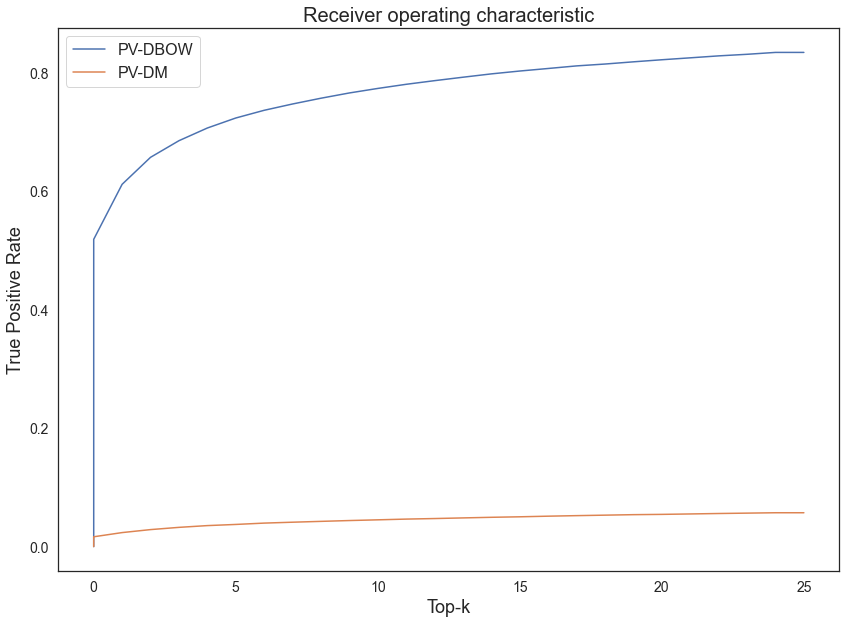

In [9]:
plt.plot(cbow_roc['top-k'], cbow_roc['TPR'], label='PV-DBOW')
plt.plot(skip_roc['top-k'], skip_roc['TPR'], label='PV-DM')
plt.xlabel("Top-k", fontsize=18)
plt.ylabel("True Positive Rate", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Receiver operating characteristic",fontsize=20)
plt.legend(prop={'size': 16})
plt.show()

# Dimensional Reduction

In [10]:
import umap.umap_ as umap

In [11]:
reducer = umap.UMAP(n_components=DIM_REDUCTION)
projection = reducer.fit_transform(model.dv.vectors) # model.dv.index_to_key 
projection

array([[ 9.23877  ,  6.179926 , -3.6132956],
       [14.826374 ,  2.620197 ,  2.4922044],
       [ 8.456755 ,  1.3364164,  3.748076 ],
       ...,
       [10.550405 ,  9.6089115,  9.401996 ],
       [10.576117 ,  9.584005 ,  9.427194 ],
       [10.578798 ,  9.537511 ,  9.454028 ]], dtype=float32)

# Clustering Analysis

In [12]:
from sklearn.cluster import DBSCAN
from matplotlib import cm

### PV-DM Model

2021-11-29 14:38:01,777 : INFO : loading Doc2Vec object from data/flavor2vec-skipgram.model
2021-11-29 14:38:01,804 : INFO : loading dv recursively from data/flavor2vec-skipgram.model.dv.* with mmap=None
2021-11-29 14:38:01,805 : INFO : loading vectors from data/flavor2vec-skipgram.model.dv.vectors.npy with mmap=None
2021-11-29 14:38:01,836 : INFO : loading wv recursively from data/flavor2vec-skipgram.model.wv.* with mmap=None
2021-11-29 14:38:01,837 : INFO : setting ignored attribute cum_table to None
2021-11-29 14:38:01,852 : INFO : Doc2Vec lifecycle event {'fname': 'data/flavor2vec-skipgram.model', 'datetime': '2021-11-29T14:38:01.852744', 'gensim': '4.1.2', 'python': '3.9.7 (default, Sep 16 2021, 08:50:36) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.14.6-x86_64-i386-64bit', 'event': 'loaded'}


(array([0., 1., 2., 3., 4., 5., 6., 7.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

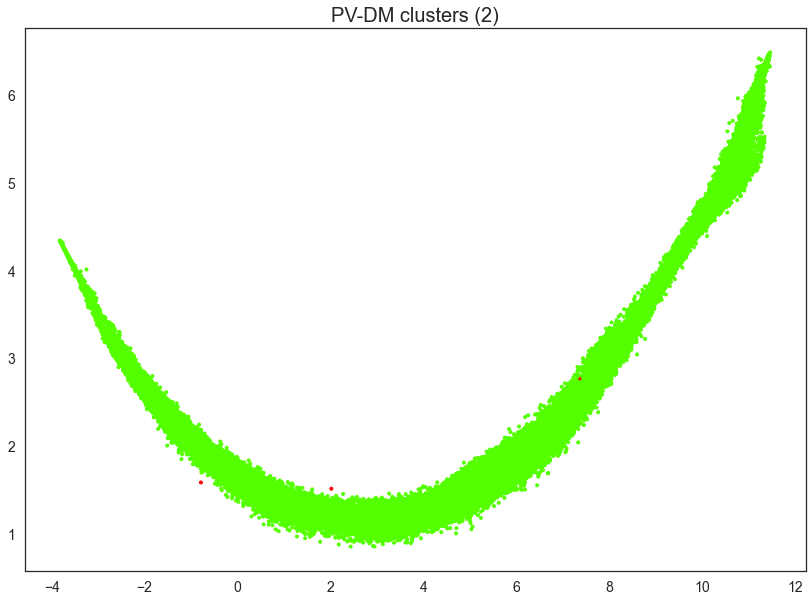

In [13]:
skip = gensim.models.doc2vec.Doc2Vec.load(MODEL_FILES['skip'])
skip_projection = reducer.fit_transform(skip.dv.vectors) # model.dv.index_to_key 

skip_clustering_df = pd.DataFrame(skip_projection, columns=('x', 'y','z'))
skip_clustering = DBSCAN(eps=.2, min_samples=10, n_jobs=-1).fit(skip_clustering_df[['x','y','z']])
skip_clustering_df['cluster'] = skip_clustering.fit_predict(skip_clustering_df[['x','y','z']])
num_clusters = len(skip_clustering_df['cluster'].unique())

cmap = cm.get_cmap('prism', num_clusters)
plt.scatter(skip_clustering_df['x'], skip_clustering_df['y'], 
            marker='.', alpha=1,
            c=skip_clustering_df['cluster'], 
            cmap=cmap
           )
plt.title(f"PV-DM clusters ({num_clusters})", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

### CBOW Model

(array([-15., -10.,  -5.,   0.,   5.,  10.,  15.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

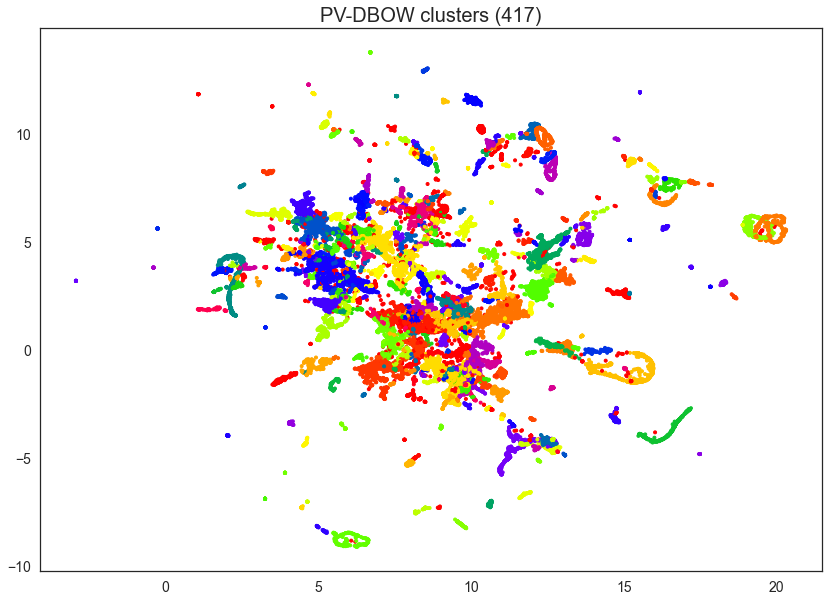

In [14]:
clustering_df = pd.DataFrame(projection, columns=('x', 'y','z'))
clustering = DBSCAN(eps=.2, min_samples=10, n_jobs=-1).fit(clustering_df[['x','y','z']])
clustering_df['cluster'] = clustering.fit_predict(clustering_df[['x','y','z']])
num_clusters = len(clustering_df['cluster'].unique())

cmap = cm.get_cmap('prism', num_clusters)
plt.scatter(clustering_df['x'], clustering_df['y'], 
            marker='.', alpha=1,
            c=clustering_df['cluster'], 
            cmap=cmap
           )
plt.title(f"PV-DBOW clusters ({num_clusters})", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [15]:
TOPN_CLUSTERS = 25

cluster_groups = clustering_df['cluster'].value_counts().T
cluster_groups = pd.DataFrame(cluster_groups)
cluster_groups = cluster_groups.reset_index()
cluster_groups.columns = ['cluster', 'items']
cluster_groups = cluster_groups.sort_values(by='items', ascending=False)
cluster_groups = cluster_groups[:TOPN_CLUSTERS]

def rgba(e):
    index = e[0]
    return (
        cmap(index)[0]*255,
        cmap(index)[1]*255,
        cmap(index)[2]*255,
        cmap(index)[3],        
    )

_flav_df = pd.merge(df, clustering_df['cluster'], left_index=True, right_index=True)

def flav_freq(row):
    terms = defaultdict(int)
    total = 0
    for j, r in _flav_df[(_flav_df.cluster == row.cluster) & (_flav_df.type == 'recipe')].iterrows():
        for m in r.flavor_molecules:
            ts = m['flavor_profile'].split('@')
            for t in ts:
                terms[t] += 1
                total += 1

    topn = dict(map(lambda e: (e[0], e[1]/total), sorted(terms.items(), key=lambda e: e[1], reverse=True)))
    return topn


cluster_groups['flav_freq'] = cluster_groups.apply(flav_freq, axis=1)
cluster_groups['total_mols'] = cluster_groups.apply(lambda r: len(_flav_df[_flav_df.cluster == r['cluster']].mols.explode().unique()), axis=1)
cluster_groups['color'] = cluster_groups.apply(rgba, axis=1)
cluster_groups['swatch'] = ['&#9608;'] * len(cluster_groups)

### Molecular Taste Distribution 

In [16]:
def taste_distribution(df):
    mol_flavors = defaultdict(int)
    for flavor_profile in df.flavor_profile:
        if type(flavor_profile) is str:
            flavors = flavor_profile.split('@')
            for flavor in flavors:
                mol_flavors[flavor] +=1
            
    total_mols = len(df)
    for k,v in mol_flavors.items():
        mol_flavors[k] = v/total_mols
        
    return pd.DataFrame(
        sorted(mol_flavors.items(), key=lambda e: e[1], reverse=True),
        columns=['taste', 'coverage']
    )

taste_dist = taste_distribution(mol_df)

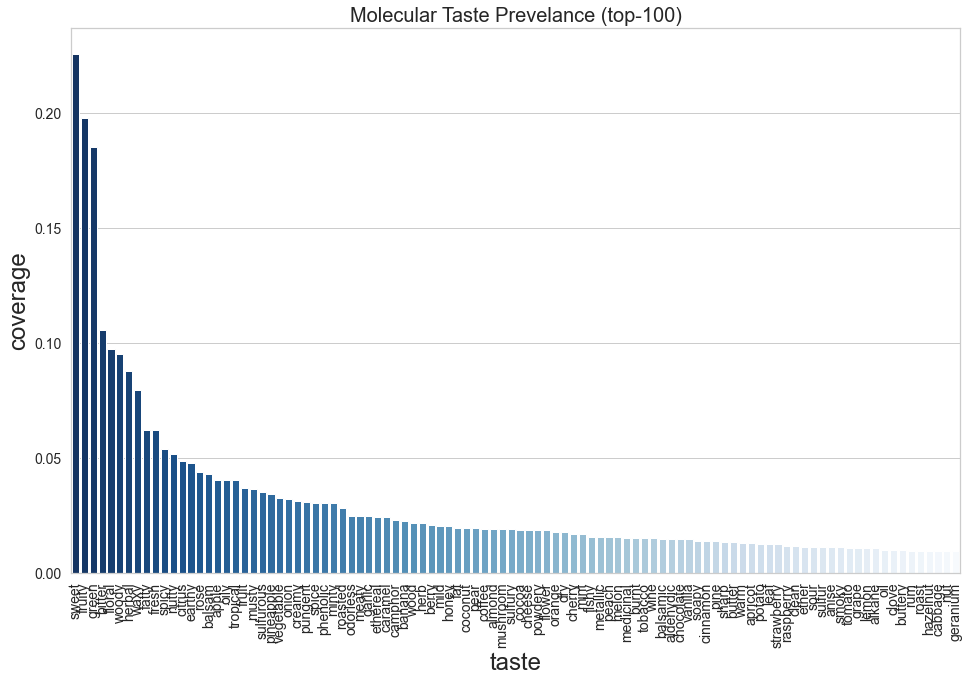

In [17]:
sns.set(font_scale = 2)
sns.set_style("whitegrid")

sns.barplot(x="taste", y="coverage", data=taste_dist[0:100], palette="Blues_r")
plt.xticks(rotation=90)
plt.title(f"Molecular Taste Prevelance (top-100)", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

In [18]:
from bokeh.application import Application
from bokeh.application.handlers import FunctionHandler
from bokeh.layouts import column, row
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ( 
    HoverTool, ColumnDataSource, Callback, DataTable, TableColumn,
    CustomJS, CategoricalColorMapper, CategoricalMarkerMapper, LinearColorMapper, Div
)
from bokeh.transform import linear_cmap
from bokeh.palettes import Cividis256, Magma256
from bokeh.models.widgets import Slider, TextInput, Select, AutocompleteInput, HTMLTemplateFormatter

logging.getLogger('bokeh').setLevel(logging.CRITICAL)
logging.getLogger('tornado').setLevel(logging.CRITICAL)

output_notebook()

Loading BokehJS ...

In [20]:
"""
TF-IDF Adapted for cluster term enrichment as term frequencey - inverse cluster frequencey
"""  

def doc_freq(df):
    terms = set(df.flav_freq.explode().unique())
    doc_freq = defaultdict(int)
    for tf in cluster_groups.flav_freq:
        for t in terms:
            if t in tf and tf[t] > 0:
                doc_freq[t] +=1
    return doc_freq


DOC_FREQ = doc_freq(cluster_groups)

def tf_idf_normalize(tf):
    total_docs = len(cluster_groups)
    tf_idf = {}
    for t,v in tf.items():
        tf_idf[t] = v*np.log2(total_docs/(1+DOC_FREQ[t]))            
    return tf_idf
    
    

In [21]:
from wordcloud import WordCloud

def common_tastes(clusters, common):
    if len(clusters) == 1:
        return common.intersection(clusters.pop().keys())
    else:
        b = clusters.pop().keys()       
        return common_tastes(clusters, common.intersection(b))

def cluster_group_mask():
    clusters = list(cluster_groups.flav_freq)
    return common_tastes(clusters[1:], set(clusters[0].keys()))

COMMON_TASTE_MASK = cluster_group_mask()


def cluster_cloud(index):
    wf = cluster_groups.iloc[index]['flav_freq']
    color = tuple(map(int, cluster_groups.iloc[index]['color'][0:3]))
    wc = WordCloud(
        background_color="white", 
        mode='RGBA', 
        scale=1.5,
        color_func=lambda *args, **kw: color # word_color(args)
    )
    return wc.generate_from_frequencies(wf)

def distinct_notes(index):
    wf = tf_idf_normalize(cluster_groups.iloc[index]['flav_freq'])
    wc = WordCloud(
        background_color="white", 
        mode='RGBA', 
        scale=1.5,
    )
    
    try:
        return wc.generate_from_frequencies(wf)
    except OSError as e:        
        wf = tf_idf_normalize(cluster_groups.flav_freq[15])
        wf = sorted(wf.items(), key=lambda e: e[1], reverse=True)
        for i in range(5):
            wf[i] = (wf[i][0], 1)
        return wc.generate_from_frequencies(dict(wf))

def cluster_app(doc):
    heading = Div(text="<h3>Cluster browser</h3><br><span>Click the clusters in the list to display thier flavor profiles</span>")
    cluster_data = ColumnDataSource(cluster_groups)
    template="""<p style="color:rgba(<%= color %>);background-color:rgba(<%= color %>);"><%= value %></p>"""
    formatter =  HTMLTemplateFormatter(template=template)
    cluster_table = DataTable( source=cluster_data,
                               index_position=None,
                               columns=[
                                   TableColumn(field='swatch',formatter=formatter,width=5),
                                   TableColumn(field="cluster", title="cluster", width=100),
                                   TableColumn(field='items', title='items',width=100),
                                   TableColumn(field='total_mols', title='molecules',width=100),
                               ],
                               selectable = True,
                               sortable = True,
                               width=280,
                               height=600
                             )

    img = cluster_cloud(0).to_array()
    ydim,xdim, z = img.shape
    dim = max(xdim, ydim)
        
    fig = figure(width=xdim, height=ydim, title="Taste Profile")    
    fig.x_range.range_padding = fig.y_range.range_padding = 0
    fig.toolbar.logo = None
    fig.toolbar_location = None
    fig.axis.visible = False
        
    fig2 = figure(width=xdim, height=ydim, title="Distinctive Notes (TF-IDF)")
    fig2.x_range.range_padding = fig.y_range.range_padding = 0
    fig2.toolbar.logo = None
    fig2.toolbar_location = None
    fig2.axis.visible = False
    
    def update_wc(attr,old,new):
        img = cluster_cloud(new[0]).to_array()
        _img = np.empty((ydim,xdim), dtype=np.uint32)
        view = _img.view(dtype=np.uint8).reshape((ydim, xdim, 4))
        view[:,:,:] = np.flipud(np.asarray(img))
        fig.image_rgba(image=[_img], x=0, y=0, dw=xdim, dh=ydim)
        
        img2 = distinct_notes(new[0]).to_array()
        _img2 = np.empty((ydim,xdim), dtype=np.uint32)
        view2 = _img2.view(dtype=np.uint8).reshape((ydim, xdim, 4))
        view2[:,:,:] = np.flipud(np.asarray(img2))
        fig2.image_rgba(image=[_img2], x=0, y=0, dw=xdim, dh=ydim)


    cluster_data.selected.on_change('indices', update_wc)
    
    doc.add_root(column(heading,row(cluster_table,column(fig, fig2))))

show(cluster_app)


# Healthy Option: Nutrition Optimizer

In [22]:
#Below just to create a sample data
# Sample code to test the code
#import pandas as pd
#df = pd.read_json('data/1M_recipes_with_nutritional_info.json')
#df['food'] = df.pop('title')
#s_df = pd.DataFrame({'id':['08f2a0465c','ing-272','0858b28796','25bd97110f','205c598aec',
#                               '1edf9efbc9','148b1b6b24','eb2b5633db','1c993c47d9','eca3abce74']})

In [23]:
#scoring system
def Score(dict_TopRecipe_ntr, preference):
    dv = [2000,78,50,6,20,50]
    
    if preference == 'Default':
        parameter = [-1,0,1,-1,0,-1]
    elif preference == 'Ketogenic':
        parameter = [0,1,1,-1,-0.5,-1]
    elif preference == 'Low Fat':
        parameter = [0,0,1,-1,-1,-1]

    dict_score = {}
    dict_energy = {}
    for i, row in dict_TopRecipe_ntr.iterrows():
        
        nutrient = [
            row['nutr_values_per100g.energy'], 
            row['nutr_values_per100g.fat'],
            row['nutr_values_per100g.protein'],
            row['nutr_values_per100g.salt'],
            row['nutr_values_per100g.saturates'],
            row['nutr_values_per100g.sugars']
        ]
        
        pct_dv = [a/b for a,b in zip(nutrient,dv)]
        wt_score = [a*b for a,b in zip(parameter,pct_dv)]
        score = sum(wt_score)
        dict_score[row['id']] = score
    
    dict_score_rank = pd.DataFrame(dict_score.items(), columns=['id', 'ntr_score'])
    return dict_score_rank.sort_values(by=['ntr_score'], ascending=False)

#helper function
# def NtrDataFlat(TopRecipe):
#     ntr_temp = TopRecipe['nutr_values_per100g']
#     df_ntr = pd.DataFrame.from_dict({(i): ntr_temp[i] for i in ntr_temp.keys()}, orient='index')
#     return TopRecipe.merge(df_ntr, left_index=True, right_index=True)


def NutritionOptimize(s_df, df, preference = 'Default'):    
    TopRecipe = df.loc[df['id'].isin(s_df['id'])]
    
    #rank the recipe
    top_n_recipe_score = Score(TopRecipe, preference)
    
    #prepare pandas table output
    out = top_n_recipe_score.merge(TopRecipe, left_on='id', right_on='id')                            
    out['%DV-energy'] = out['nutr_values_per100g.energy']*100/2000
    out['%DV-fat'] = out['nutr_values_per100g.fat']*100/78
    out['%DV-protein'] = out['nutr_values_per100g.protein']*100/50
    out['%DV-salt'] = out['nutr_values_per100g.salt']*100/6
    out['%DV-saturates'] = out['nutr_values_per100g.saturates']*100/20
    out['%DV-sugars'] = out['nutr_values_per100g.sugars']*100/50
    out = out[['id','food','%DV-energy','%DV-fat','%DV-protein','%DV-salt','%DV-saturates','%DV-sugars']]
    return out.round(1)

#### The healthy ranking of the top 10 matched recipe from CHICKEN

In [24]:

if gensim_version >= 4:
    similars = model.dv.most_similar(positive=[model.dv.vectors[51507]])
else:
    similars = model.dv.most_similar(model.dv.vectors[51507])
s_df = pd.DataFrame(similars, columns=['id','similarity']).astype({'id': 'string'})

In [25]:
nutrional_opt_df = NutritionOptimize(s_df, df,'Default')
nutrional_opt_df

,id,food,%DV-energy,%DV-fat,%DV-protein,%DV-salt,%DV-saturates,%DV-sugars
0,0639846784,Chicken Satay Recipe,6.0,3.4,45.0,1.9,2.8,0.0
1,0858b28796,Giblet Gravy (For Poultry),6.0,3.4,45.0,1.9,2.8,0.0
2,d77841136d,BBQ Chicken on the Grill,6.2,3.1,41.1,5.6,2.6,6.0
3,eb2b5633db,Mexican Style Chicken,4.6,2.3,31.5,11.6,1.9,2.0
4,0e763c3e60,It Won't Burn! Soy Sauce and Mayonnaise Chicke...,8.5,10.2,38.9,15.3,6.9,7.3
5,f116261e0d,The Easiest Barbecued Chicken Wings Ever!!!,9.4,13.9,29.5,10.0,14.8,11.1
6,ed8488ed90,Campbell's 2 Step Creamy Chicken and Pasta,6.0,15.3,5.4,2.4,15.0,0.1
7,eca3abce74,Crockpot BBQ Chicken,7.1,3.8,32.0,12.8,2.7,20.7
8,08f2a0465c,Grilled Chipotle and Cola BBQ Chicken,5.5,0.9,5.2,20.6,0.4,39.9
9,ing-272,Chicken,NaN,NaN,NaN,NaN,NaN,NaN


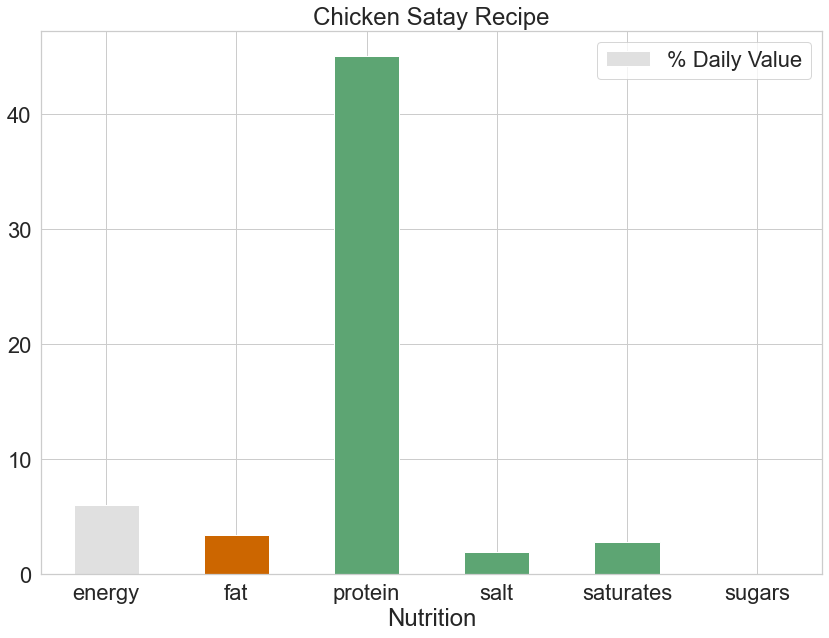

In [26]:
def PlotNutritionDV(NtrOptimize_df):
    color = NtrColor(NtrOptimize_df)
    ntr_plot = pd.DataFrame({'Nutrition':['energy', 'fat', 'protein', 'salt', 'saturates', 'sugars'], 
                             '% Daily Value':[NtrOptimize_df['%DV-energy'].iloc[0], 
                                              NtrOptimize_df['%DV-fat'].iloc[0], 
                                              NtrOptimize_df['%DV-protein'].iloc[0],
                                              NtrOptimize_df['%DV-salt'].iloc[0],
                                              NtrOptimize_df['%DV-saturates'].iloc[0],
                                              NtrOptimize_df['%DV-sugars'].iloc[0]]})
    ntr_plot.plot.bar(x='Nutrition', y='% Daily Value', title=NtrOptimize_df['food'][0], rot=0, color=color)
    
    #heper function
def NtrColor(NtrOptimize_df):
    color = []
    col = '#E0E0E0'
    for column in NtrOptimize_df:
        if column in ['%DV-salt', '%DV-saturates', '%DV-sugars']:
            if NtrOptimize_df[column].iloc[0] < 5.0:
                col = '#5DA573'
            elif (NtrOptimize_df[column].iloc[0] >= 5.0) and (NtrOptimize_df[column].iloc[0] < 20.0):
                col = '#FFCC99'
            else:
                col = '#CC6600'
            
        elif column in ['%DV-fat', '%DV-protein']:
            if NtrOptimize_df[column].iloc[0] < 5.0:
                col = '#CC6600'
            elif (NtrOptimize_df[column].iloc[0] >= 5.0) and (NtrOptimize_df[column].iloc[0] < 20.0):
                col = '#B1D1BA'
            elif NtrOptimize_df[column].iloc[0] >= 20.0:
                col = '#5DA573'

        color.append(col)
    return color[2:]

plot = PlotNutritionDV(nutrional_opt_df)

# Visualize Flavor Space

In [27]:
SPACE_SIZE = 10000 # Adjust based on broswer performance capability
projection_df = pd.DataFrame(projection[:SPACE_SIZE], columns=('x', 'y','z'))
projection_df['id'] = model.dv.index_to_key[:SPACE_SIZE]
projection_df['food'] = df['food'][:SPACE_SIZE]
projection_df['type'] = df['type'][:SPACE_SIZE]
projection_df['ingredient'] = df['unique_ingredient'][:SPACE_SIZE]
projection_df['ingredient_count'] = df['ingredient_count'][:SPACE_SIZE]
projection_df['cluster'] = clustering_df['cluster']
projection_df['color'] = projection_df['cluster'].apply(lambda v: tuple(rgba((v,0))[0:3]))

selected_indexes = []

In [28]:
## find nearest neighbors
def findSimilars(food="", type_="recipe", limit=0):
    if food == "":
        return projection_df, pd.DataFrame(columns=projection_df.columns)
    if not type_ in ["recipe", "ingredient", "all"]:
        raise Exception("Wrong food type, type must be one of 'recipe, ingredient, all' ")
    i=3
    row = df.loc[df['food']==food]
    flavor_vec = model.infer_vector(row.iloc[0]['mol_doc'].words)
    if gensim_version >= 4:
        similars = model.dv.most_similar(positive=[flavor_vec],topn=30)
    else:
        similars = model.dv.most_similar(flavor_vec,topn=30)
    indices = [x[0] for x in similars]
    indices.append(row["id"].iloc[0])
    selected_df = projection_df[projection_df["id"].isin(indices)]
    selected_df = selected_df[selected_df["type"] == type_]
    if type_ == 'recipe':
        selected_df = selected_df[selected_df['ingredient_count'] > limit]
    selected_df = selected_df.iloc[:10]
    nonselected_df = projection_df[~projection_df["id"].isin(selected_df['id'])]
    return nonselected_df, selected_df

In [29]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)                 

fig = figure(
    title='UMAP projection of the Flavor Space',
    plot_width=800,
    plot_height=600,
    tools=('pan, wheel_zoom, reset, lasso_select')
)

fig.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <span style='font-size: 16px; color: #224499'>ID: @id</span>
        <span style='font-size: 18px'>@food</span>
    </div>
</div>
"""))

## prepare data
nonselected_df, selected_df = findSimilars()
chart_data = ColumnDataSource(nonselected_df)
highlighted_data = ColumnDataSource(selected_df)
table_data = ColumnDataSource(dict(id=highlighted_data.data["id"], 
                           food=highlighted_data.data["food"], 
                           type=highlighted_data.data["type"], 
                           ingredient = highlighted_data.data["ingredient"],
                           ingredient_count=highlighted_data.data["ingredient_count"]
                          ))
color_map = LinearColorMapper(palette=Magma256, low=projection_df['cluster'].min(), high=projection_df['cluster'].max())
marker_map = CategoricalMarkerMapper(factors=projection_df['type'].unique(), markers=['circle', 'triangle'])

chart = fig.scatter(
    'x',
    'y',
    source=chart_data,
    marker=dict(field='type', transform=marker_map),
    fill_color='color',
    line_color=None,
    size=6
)

## drawing scatter of selected data in red color
highlighted_chart = fig.scatter(
    'x',
    'y',
    source=highlighted_data,
    color="pink",
    line_color="black",
    fill_alpha=0.7,
    size=15
)




chart_data.selected.js_on_change('indices', 
     CustomJS(args=dict(chart_data=chart_data, table_data=table_data), 
              code="""
                var selected_indexes = cb_obj.indices;
                console.log(selected_indexes)
                table_data.data['index'] = selected_indexes;
                table_data.data['id'] = [];
                table_data.data['food'] = [];
                table_data.data['ingredient'] = [];
                table_data.data['ingredient_count'] = [];
                table_data.data['type'] = [];
                for (let i=0;i<selected_indexes.length;i++){
                    table_data.data['id'].push(chart_data.data['id'][selected_indexes[i]]);
                    table_data.data['food'].push(chart_data.data['food'][selected_indexes[i]]);
                    table_data.data['type'].push(chart_data.data['type'][selected_indexes[i]]);
                    table_data.data['ingredient'].push(chart_data.data['ingredient'][selected_indexes[i]]);
                    table_data.data['ingredient_count'].push(chart_data.data['ingredient_count'][selected_indexes[i]]);
                }                
                
                // var kernel = IPython.notebook.kernel;
                // IPython.notebook.kernel.execute("selected_indexes = " + selected_indexes);
                
                table_data.change.emit();
                """
             )
)

## display the selected data
table = DataTable(source=table_data, sizing_mode="stretch_width", columns=[
    TableColumn(field='id'),
    TableColumn(field='food'),
    TableColumn(field='type'),
    TableColumn(field='ingredient'),
    TableColumn(field='ingredient_count'),
])

#### config user input widgets
def updateData(food, type_, limit):
    nonselected_df, selected_df = findSimilars(food=food, type_=type_, limit=int(limit))
    # update data
    chart_data.data = nonselected_df
    highlighted_data.data = selected_df
    table_data.data = dict(id=highlighted_data.data["id"], 
                           food=highlighted_data.data["food"], 
                           ingredient = highlighted_data.data["ingredient"],
                           ingredient_count=highlighted_data.data["ingredient_count"],
                           type=highlighted_data.data["type"]
                          )

    
## text input for food input
def text_input_callback(attr, old, new):
    updateData(food=text_input.value, type_=select_type_filter.value, limit=int(select_ingredient_filter.value))

# get all possible entries
recipe_list = df[df['type'] == "recipe"]["food"].tolist()
ingr_list = df[df['type'] == "ingredient"]["food"].tolist()

text_input = AutocompleteInput(title="Food Name", value='', completions=recipe_list, case_sensitive=False)       
text_input.on_change("value",text_input_callback)


## filtration food with only 1 or 2 ingredients
def ingredient_filter_callback(attr, old, new):
    updateData(food=text_input.value, type_=select_type_filter.value, limit=int(select_ingredient_filter.value))

select_ingredient_filter = Slider(start=0, end=5, value=0, step=1, title="Food with at least N ingredients")
select_ingredient_filter.on_change("value", ingredient_filter_callback)


## type filtration
def type_filter_callback(attr, old, new):
    if select_type_filter.value == 'recipe':
        text_input.completions = recipe_list
    else:
        text_input.completions = ingr_list
    text_input.value = ""
    updateData(food=text_input.value, type_=select_type_filter.value, limit=int(select_ingredient_filter.value))
    
select_type_filter = Select(title="Food type", value="recipe", options=["recipe", "ingredient"])
select_type_filter.on_change("value", type_filter_callback)


## Nutrition Optimizer
nutrition_fig = figure(
    x_range=['%DV-energy','%DV-fat','%DV-protein','%DV-salt','%DV-saturates','%DV-sugars'],
    y_range=[0,100],
    title='Healthy Choice Nutrition Profile',
    plot_width=400,
    plot_height=400,
    toolbar_location=None,
    tools=''
)

nutrition_heading = Div(text='<h3>Nutrional Rankings (%Daily Value) -- higher is better</h3>')
nutrition_fig.toolbar.logo = None
nutrition_fig.toolbar_location = None
nutrition_data = ColumnDataSource()
nutrition_chart_data = ColumnDataSource(data=dict(nut=[], dv=[]))
nutrition_table = DataTable(
    source=nutrition_data, 
    width=500, 
    index_position=None,
    columns=[
        TableColumn(field='food', width=200),
        TableColumn(field='%DV-energy', title='energy', width=50),
        TableColumn(field='%DV-fat', title='fat', width=50),
        TableColumn(field='%DV-protein', title='protein', width=50),
        TableColumn(field='%DV-salt', title='salt', width=50),
        TableColumn(field='%DV-saturates', title='sat.', width=50),
        TableColumn(field='%DV-sugars', title='sugar', width=50)
])

nutrition_fig.vbar(
    x='nut',
    top='dv',
    width=0.9,
    source=nutrition_chart_data
)
nutrition_fig.xaxis.major_label_orientation = "vertical"

def nutrition_filter_callback(attr, old, new):
    ###############
    #### placeholder optimization algorithm here!
    ##############
    n_df = NutritionOptimize(highlighted_data.data, df, select_nutrition_filter.value)
    nutrition_data.data = n_df
    top1 = n_df.drop(columns=['id', 'food']).iloc[0]
    nutrition_chart_data.data['nut'] = top1.index.tolist()
    nutrition_chart_data.data['dv'] = top1.values.tolist()
    nutrition_fig.title.text = n_df.iloc[0]['food']
    

select_nutrition_filter = Select(title="Nutrition Priority", value="Select One", options=["Select One", "Default", "Ketogenic", "Low Fat"])
select_nutrition_filter.on_change("value", nutrition_filter_callback)


# Set up layouts and add to document

layout = row(column(row(column(select_type_filter, text_input), column(select_ingredient_filter,select_nutrition_filter)), fig),column(table, nutrition_heading, row(nutrition_table, nutrition_fig)))

def modify_doc(doc):
    doc.add_root(row(layout, width=800))
    return doc


handler = FunctionHandler(modify_doc) # A Handler that accepts a plain python function to use for modifying Bokeh Documents.
app = Application(handler)
show(app)

# "Tastes like Chicken!"

In [30]:
def ingredient_filtered(row, term=''):
    if type(row) == float or row is None:
        return True
    
    for el in row:
        if term in el:
            return True
    return False

def tastes_like(flavor_index, exclude_ingredient, topn=5):
    row = df.iloc[flavor_index]
    flavor_vec = model.dv.vectors[flavor_index]
    if gensim_version >= 4:
        df['_sim'] = model.dv.most_similar([flavor_vec], topn=None)
    else:
        df['_sim'] = model.dv.most_similar(flavor_vec, topn=None)
        
    df['_present'] = df['unique_ingredient'].apply(ingredient_filtered, term=exclude_ingredient.lower())    
    return df[~df._present].sort_values(['_sim'], ascending=False)[:topn]
     

In [31]:
QUERY_INDEX = 51507
df.iloc[QUERY_INDEX][['id','food','unique_ingredient']]

id                   ing-272
food                 Chicken
unique_ingredient       None
Name: 51507, dtype: object

In [32]:
tastes_like(QUERY_INDEX, exclude_ingredient='Chicken', topn=10)[['id','food','unique_ingredient','_sim']]

,id,food,unique_ingredient,_sim
47916,ef4a9bec66,Bbq rotisserie smoked turkey,"[ground turkey, raw]",0.534512
46349,e768b479b4,Thankgiving Day Turkey,"[ground turkey, raw, water, bottled, generic, ...",0.533408
50751,fd74454535,Cajun Deep Fried Turkey (Houston Chronicle) Re...,"[ground turkey, raw]",0.529180
46151,e67b50494c,Gorilla Fart,"[alcoholic beverage, distilled, rum, 80 proof,...",0.528323
45523,e35bc46e21,Flaming Orgy,"[ground turkey, raw, alcoholic beverage, disti...",0.524276
14509,48a9f25708,Easy 3-Minute Microwave Caramel Sauce,"[sugars, granulated, water, bottled, generic]",0.511129
33357,a643679b3e,Reuben Sandwich,"[ground turkey, raw]",0.510742
43140,d7c5341369,Desert Fire,"[alcoholic beverage, tequila sunrise, canned, ...",0.509866
6633,20b9cde664,Recipe no longer on file Recipe aricat,"[water, bottled, generic]",0.507073
11117,3778c7e07e,Toffees,"[sugars, granulated, water, bottled, generic, ...",0.504166


# Computational Cooking!

In [33]:
# Locate food vectorsa
df[(df.type == 'ingredient') & (df['food'].str.contains('Potato'))];

## What molecules determine meat flavor?

In [34]:
meat_vec_ids = [51507,51515,51513,51505,51510]
df.iloc[meat_vec_ids]

,id,food,unique_ingredient,ingredient_count,category_freq,instructions,flavor_molecules,molecules_count,nutr_values_per100g.energy,nutr_values_per100g.fat,...,entity_alias_basket,natural_source_name,entity_alias,molecules,natural_source_url,entity_alias_url,entity_alias_synonyms,mol_doc,_sim,_present
51507,ing-272,Chicken,None,NaN,None,None,None,131,NaN,NaN,...,"chicken, chicken-boiled, chicken-broth, chicke...",Fowl,chicken,"[{'atom_stereo_count': 0, 'bitter': 0, 'bitter...",https://en.wikipedia.org/wiki/Fowl,https://en.wikipedia.org/wiki/Chicken,Chicken,"([5367531, 20083, 5283349, 7501, 7363, 5352461...",1.000000,True
51515,ing-280,Turkey,None,NaN,None,None,None,17,NaN,NaN,...,"turkey, turkey-cooked, turkey-roasted",Domesticate Turkey,turkey,"[{'atom_stereo_count': 0, 'bitter': 1, 'bitter...",https://en.wikipedia.org/wiki/Domesticated_turkey,https://en.wikipedia.org/wiki/Turkey_meat,Turkey,"([6202, 644104, 20861, 6274, 520108, 11449, 52...",0.527499,True
51513,ing-278,Pork,None,NaN,None,None,None,157,NaN,NaN,...,"pork, pork-bacon, pork-boiled, pork-cooked, po...",Domestic Pig,pork,"[{'atom_stereo_count': 0, 'bitter': 0, 'bitter...",https://en.wikipedia.org/wiki/Domestic_pig,https://en.wikipedia.org/wiki/Pork,"Pork, Bacon","([5367531, 10558, 61260, 10448, 7363, 8468, 11...",0.480730,True
51505,ing-270,Beef,None,NaN,None,None,None,92,NaN,NaN,...,"beef, beef-canned, beef-extract, beef-liver, b...",Cattle,beef,"[{'atom_stereo_count': 1, 'bitter': 0, 'bitter...",https://en.wikipedia.org/wiki/Cattle,https://en.wikipedia.org/wiki/Beef,Beef,"([20083, 7501, 643731, 11509, 985, 1123, 6584,...",0.478433,True
51510,ing-275,Lamb,None,NaN,None,None,None,37,NaN,NaN,...,"lamb, lamb-cooked, lamb-fat, lamb-liver, lamb-...",Sheep,lamb,"[{'atom_stereo_count': 1, 'bitter': 0, 'bitter...",https://en.wikipedia.org/wiki/Sheep,https://en.wikipedia.org/wiki/Sheep,Lamb,"([20653, 61840, 62089, 5281, 7909, 5283321, 52...",0.296368,True


In [35]:
def common_mols(vec_ids, common):
    if len(vec_ids) == 1:
        i = vec_ids.pop()
        b = set(df.iloc[i].mols)
        return common.intersection(b)
    else:
        i = vec_ids.pop()
        b = set(df.iloc[i].mols)
        return common_mols(vec_ids, common.intersection(b))

In [36]:
meat_mols = common_mols(meat_vec_ids[1:], set(df.iloc[meat_vec_ids[0]].mols))
meat_vec = model.infer_vector(meat_mols, epochs=100)
if gensim_version >= 4:
    similars = model.dv.most_similar(positive=[meat_vec])
else:
    similars = model.dv.most_similar(meat_vec)
    
s_df = pd.DataFrame(similars, columns=['id','similarity']).astype({'id': 'string'})
s_df.reset_index().merge(df, on='id', how='left')[['id','similarity','food']]

,id,similarity,food
0,ing-316,0.867916,Macaroni
1,ing-273,0.854305,Frankfurter Sausage
2,56b5ef3b8c,0.777342,Baked Brie Recipe
3,ing-274,0.761964,Ham
4,ing-61,0.621570,Buttermilk
5,ing-948,0.618727,Empanada
6,ing-965,0.609645,Potato gratin
7,ing-667,0.609162,Broad whitefish
8,ing-695,0.607116,Walrus
9,ing-713,0.604337,Spot croaker


## Finding the perfect snack

In [37]:
food_vec_ids = [51522,51550,51608]
df.iloc[food_vec_ids]

,id,food,unique_ingredient,ingredient_count,category_freq,instructions,flavor_molecules,molecules_count,nutr_values_per100g.energy,nutr_values_per100g.fat,...,entity_alias_basket,natural_source_name,entity_alias,molecules,natural_source_url,entity_alias_url,entity_alias_synonyms,mol_doc,_sim,_present
51522,ing-287,Peanut,None,NaN,None,None,None,212,NaN,NaN,...,"peanut, peanut-roasted",Arachis,peanut,"[{'atom_stereo_count': 1, 'bitter': 0, 'bitter...",https://en.wikipedia.org/wiki/Arachis,https://en.wikipedia.org/wiki/Peanut,"Groundnut, Goober","([6436017, 5367531, 323, 107971, 12779, 7501, ...",0.210739,True
51550,ing-315,Honey,None,NaN,None,None,None,60,NaN,NaN,...,honey,Bees,honey,"[{'atom_stereo_count': 0, 'bitter': 0, 'bitter...",https://en.wikipedia.org/wiki/Bee,https://en.wikipedia.org/wiki/Honey,Honey,"([7362, 12529, 7795, 11124, 7501, 12180, 7150,...",0.378575,True
51608,ing-373,Potato,None,NaN,None,None,None,254,NaN,NaN,...,"potato, potato-baked, potato-boiled, potato-ca...",Solanum,potato,"[{'atom_stereo_count': 0, 'bitter': 1, 'bitter...",https://en.wikipedia.org/wiki/Solanum,https://en.wikipedia.org/wiki/Potato,Potato,"([323, 107971, 12209, 5283349, 7284, 10448, 71...",0.268854,True


In [38]:
peanut = model.dv.vectors[51522]
honey = 0.5*model.dv.vectors[51550]
potato = model.dv.vectors[51608]

In [39]:
if gensim_version >= 4:
    similars = model.dv.most_similar(positive=[peanut+honey+meat_vec-potato])
else:
    similars = model.dv.most_similar(peanut+honey+meat_vec-potato)
    
s_df = pd.DataFrame(similars, columns=['id','similarity']).astype({'id': 'string'})
s_df.reset_index().merge(df, on='id', how='left')[['id','similarity','food']]

,id,similarity,food
0,ing-287,0.658030,Peanut
1,0701eaacca,0.465953,Our Favorite Honey Mustard Dipping Sauce
2,0dad22345c,0.465028,Sweet and Sour Dessert Sauce
3,55fd67cb53,0.463740,Honey-Glazed Pecans
4,0900bf63ce,0.460018,Tvp Honey Nuggets
5,5458cb64e2,0.458749,Basic Honey Taffy Recipe
6,6f064cf896,0.458296,honey glaze
7,5f0bce31be,0.457819,Chick-Fil-A Sauce
8,51124bc61a,0.457385,Homemade Butter
9,67f4e034a0,0.457370,Woodland White Sauce


# Save Flavor Space Artifacts

In [40]:
if not LOAD_FROM_FILE:
    df.drop(columns=['mol_doc']+[c for c in df.columns if c.startswith('_')]).to_parquet(DATAFRAME_FILE)
    mol_df.to_parquet(FLAVMOL_FILE)